<p style="background-color:#6495ED;color:black;font-size:22px;text-align:center;border-radius:10px 10px;font-weight:bold;border:2px solid #6495ED;">Real or Fake News Classifier📰</p>



<center><img src= "https://raw.githubusercontent.com/ashwinshetgaonkar/kaggle-kernel-images/main/fake%20news.png" alt ="Fake News" style='width:600px;'></center><br>






<h3 style='font-weight:bold'>
    <li>Fake news is false or misleading information presented as news.</li><br>
    <li>Fake news often has the aim of damaging the reputation of a person or entity, or making money through advertising revenue.</li><br>
    <li>Real news is written by professional journalists who adhere to ethical guidelines for gathering and writing the news.</li></h3>

<p style="background-color:#6495ED;color:black;font-size:20px;text-align:center;border-radius:30px 60px;font-weight:bold;border:3px solid #6495ED;">Importing Libraries</p>


In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook',font_scale=1.25)
from wordcloud import WordCloud,STOPWORDS
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML,display
import re
import timeit
import gc

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras import mixed_precision

In [3]:
! pip install datasets --quiet

In [4]:
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer,DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification

<p style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Importing Data</p>


In [5]:
df=pd.read_csv('../input/fake-or-real-news/fake_or_real_news.csv',index_col=[0]).reset_index(drop=True)
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Basic EDA</span>


In [6]:
# checking the number of rows and columns
rows,columns=df.shape[0],df.shape[1]

In [7]:
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>There are {rows} rows and {columns} columns.</li></ul></h3>"))

In [8]:
# checking for duplicate instances
no_of_duplicates=df.duplicated().sum()

In [9]:
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>There are {no_of_duplicates} number of duplicate values which need to be dropped.</li></ul></h3>"))

In [10]:
# dropping the duplicate values
df.drop_duplicates(inplace=True)

In [11]:
# checking for NaN values.
no_of_nan_values=df.isna().sum().sum()

In [12]:
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>There are {no_of_nan_values} NaN values.</li></ul></h3>"))

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Feature Engineering</span>


In [13]:
df['title_word_count']=df['title'].apply(lambda x:len(x.split()))
df['text_word_count']=df['text'].apply(lambda x:len(x.split()))
df['all_text']=df['title']+"\n"+df['text']
df['all_text_word_count']=df['all_text'].apply(lambda x:len(x.split()))

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Visualizing the Data</span>


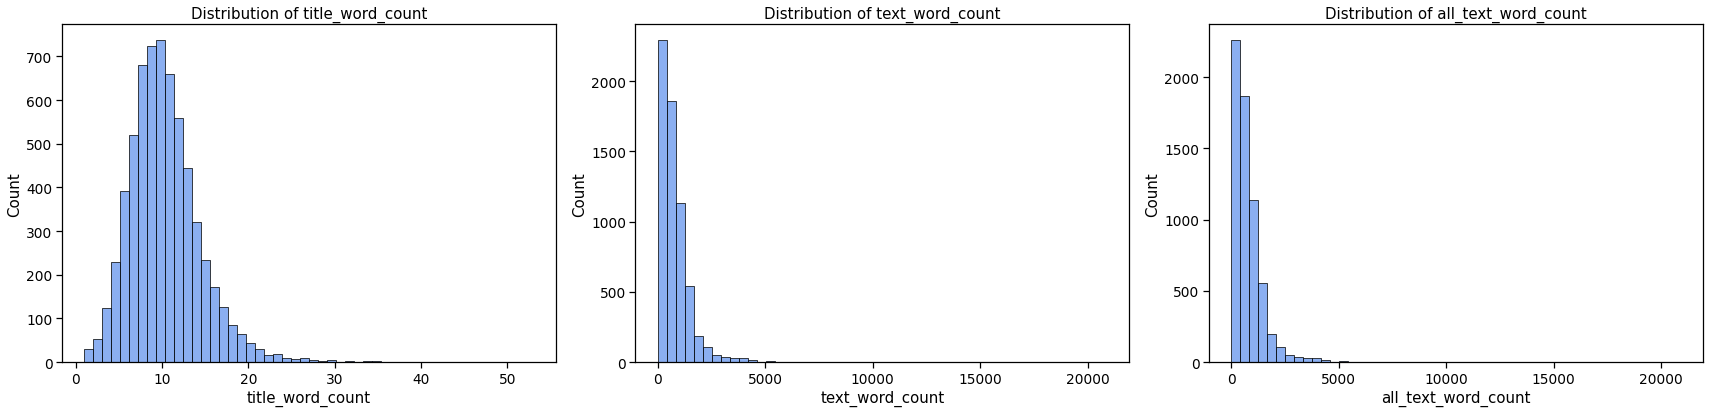

In [14]:
numerical_cols=df.select_dtypes(include=np.number).columns.to_list()
display(HTML("<h3 style='color:red;font-size:22px;padding:0px 0px 0px 0px;font-weight:bold; text-align:center'> Distribution of Various word counts</h3>"))
plt.figure(figsize=(24,6))
for i,col in enumerate(numerical_cols):
    plt.subplot(1,3,i+1)
    sns.histplot(data=df,x=col,bins=50,color='#6495ED')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>The distribution of title count follows Normal Distribution.</li><br><li>The distribution of text word count is Right skewed and contains a lot of outliers.</li></ul></h3>"))

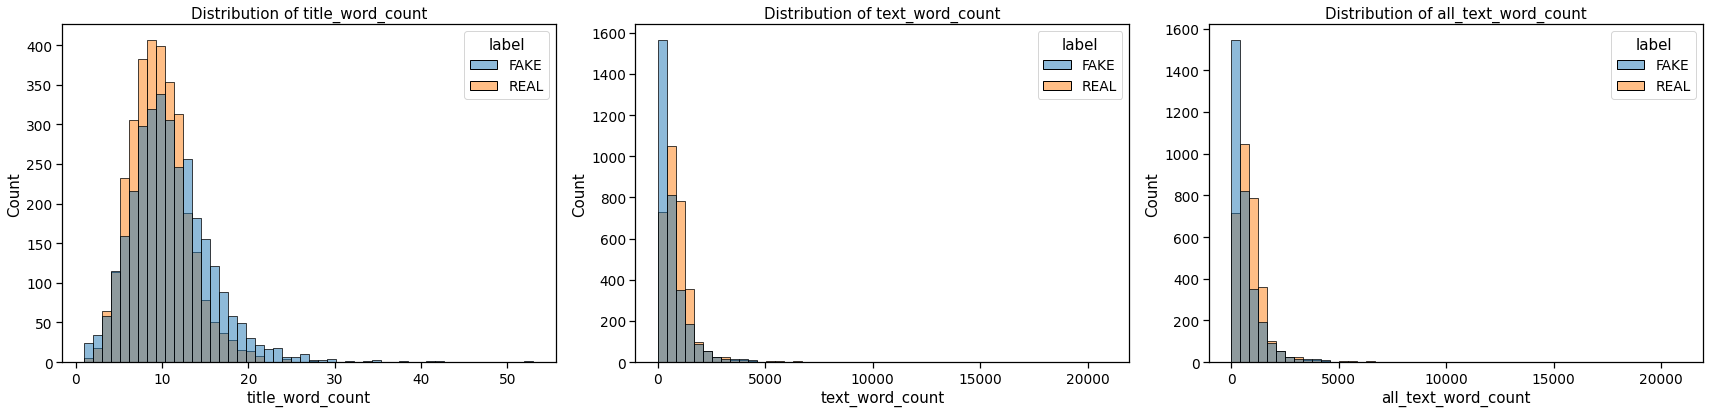

In [15]:
display(HTML("<h3 style='color:red;font-size:22px;padding:0px 0px 0px 0px;font-weight:bold; text-align:center'> Distribution of Various word counts with respect to target</h3>"))

plt.figure(figsize=(24,6))
for i,col in enumerate(numerical_cols):
    plt.subplot(1,3,i+1)
    sns.histplot(data=df,x=col,hue='label',bins=50)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>No conclusive trend seen.</li></ul></h3>"))

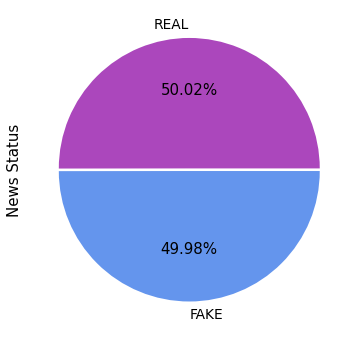

In [16]:
display(HTML("<h3 style='color:red;font-size:22px;padding:0px 0px 0px 70px;font-weight:bold; text-align:left'> Distribution of target</h3>"))
plt.figure(figsize=(10,6))
colors=['#AB47BC','#6495ED']
plt.pie(df['label'].value_counts(),labels=['REAL','FAKE'],autopct='%.2f%%',explode=[0.01,0.01],colors=colors);
plt.ylabel('News Status');

In [17]:
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>The dataset is balanced.</li></ul></h3>"))

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Most common words present in FAKE NEWS title</span>


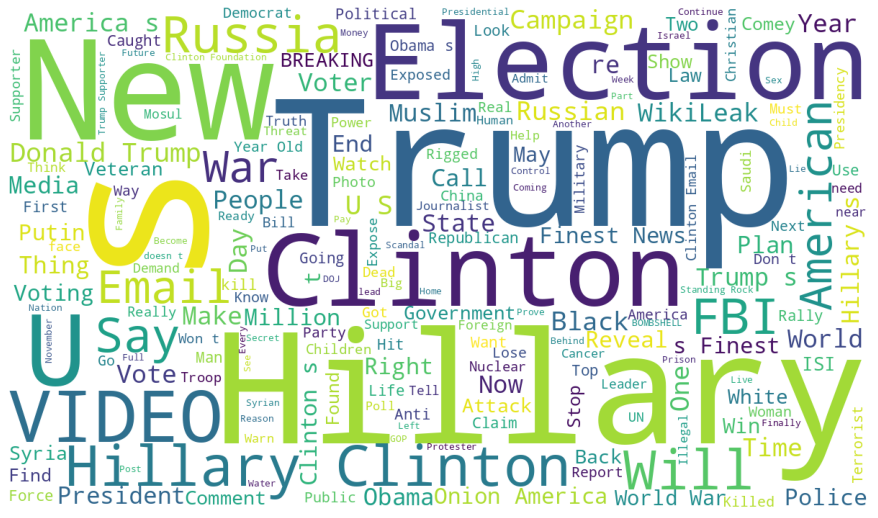

In [18]:
text_list=df.loc[df['label']=='FAKE','title'].tolist()
text=""
for sent in text_list:
    text=re.sub("[^A-Za-z0-9]"," ",text)
    text+=sent    

stopwords=set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Most common words present in REAL NEWS title</span>


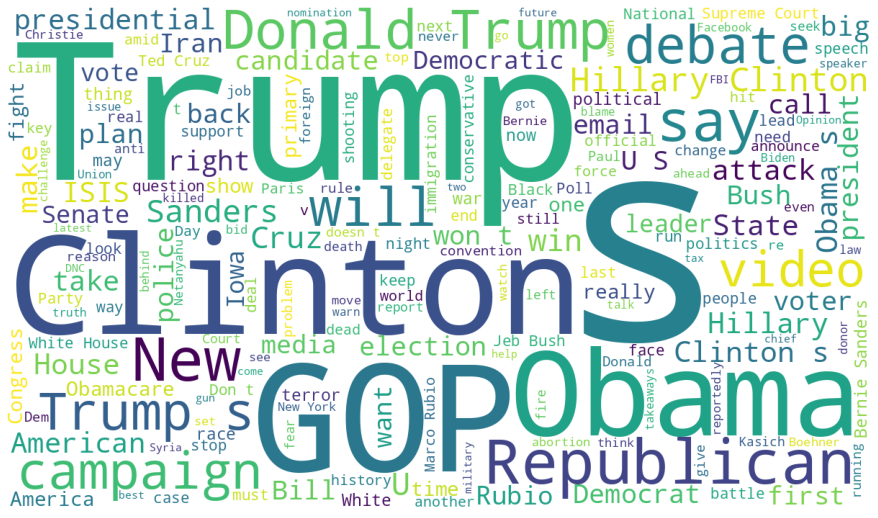

In [19]:
text_list=df.loc[df['label']=='REAL','title'].tolist()
text=""
for sent in text_list:
    text=re.sub("[^A-Za-z0-9]"," ",text)
    text+=sent    

stopwords=set(STOPWORDS)
wordcloud = WordCloud(width=1200,height=700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Visualizing the Instances</span>


In [20]:
random_index=random.randint(0,df.shape[0]-6)
for row in df[['title','text','label']][random_index:random_index+5].itertuples():
    _,title,text,label=row
    display(HTML(f"<h3><br><b style='color:red'>Title:</b>{title}</h3>"))
    display(HTML(f"<h3><b style='color:red'>Text:</b>{text}</h3>"))
    display(HTML(f"<h3><b style='color:red'>Target:</b>{label}<br><br><hr></h3>"))

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Encoding the labels</span>


In [21]:
df['label']=np.where(df['label']=='FAKE',0,1)

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Splitting the data into train and test</span>

In [22]:
xtrain,xtest,ytrain,ytest=train_test_split(df['all_text'].to_numpy(),df['label'].to_numpy(),test_size=0.2,stratify=df['label'].to_numpy())

In [23]:
xtrain.shape,xtest.shape,ytrain.shape,ytest.shape

((5044,), (1262,), (5044,), (1262,))

<p style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Modelling</p>


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 210px">model_0</span>
<h3><li>Using Naive Bayes (MultinomialNB) model to define the baseline accuracy.</li><hr></h3>


In [24]:
# define the model
model_0=Pipeline([
    ('tf-idf',TfidfVectorizer(stop_words='english')),
    ('clf',MultinomialNB())
])

In [25]:
# fit the model
model_0.fit(xtrain,ytrain)

Pipeline(steps=[('tf-idf', TfidfVectorizer(stop_words='english')),
                ('clf', MultinomialNB())])

In [26]:
def binary_clf_evaluation(y_true,y_pred,time_taken):
    '''
    accepts true and predicted labels and calculates accuracy,precision,recall and f1_score
    '''
    model_accuracy=accuracy_score(y_true,y_pred)
    
    model_precision,model_recall,model_f1_score,_=precision_recall_fscore_support(y_true,y_pred,average='weighted')
    
    results={'accuracy':model_accuracy,
             'precision':model_precision,
             'recall':model_recall,
             'f1_score':model_f1_score,
             'time/instance':time_taken
            }
    return results

def store_results(exp_result,exp_name,overall_result=pd.DataFrame()):
    '''
    accepts the dictinary containing the various evaluation metrics for a experiment,the 
    experiment name and overall_result Dataframe and return the overall_result 
    dataframe after concatinating the results of exp_name
    '''
    df=pd.DataFrame(exp_result,index=[exp_name])
    return pd.concat([overall_result,df],axis=0)

def display_results(d):
    '''Takes a dictionary as input and display it using HTML.'''
    display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Model Performance</b>:</h3>"))
    for key,value in d.items():
        if key == "accuracy":
            display(HTML(f"<h3> <b style='color:#6495ED;font-size:22px;'>{key}</b>:  {value*100:.2f}%</h3>"))
        elif key=='time/instance':
            display(HTML(f"<h3> <b style='color:#6495ED;font-size:22px;'>{key}</b>:  {value:.4f} seconds</h3>"))

        else:
            display(HTML(f"<h3> <b style='color:#6495ED;font-size:22px;'>{key}</b>:  {value:.2f}</h3>"))

    

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">model Results</span>



In [27]:
start_time=timeit.default_timer()
model_0_pred=model_0.predict(xtest)
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_0_results=binary_clf_evaluation(ytest,model_0_pred,time_taken_per_instance)
display_results(model_0_results)
overall_results=store_results(model_0_results,"model_0")

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Converting Data to TensorFlow Performant Databatches</span>


In [28]:
training_dataset=tf.data.Dataset.from_tensor_slices((xtrain,ytrain)).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
test_dataset=tf.data.Dataset.from_tensor_slices((xtest,ytest)).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

2022-04-12 10:14:21.548934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 10:14:21.550243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 10:14:21.550993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 10:14:21.553492: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 210px">model_1</span>
<h3><li>Using a feed forword Neural Network.</li><hr></h3>


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Tokenization & Vectorization</span>
<h3><li>Here each instance text will be converted into tokens(words) and then it is represented using Numbers.</li></h3>



In [29]:
# define the max vacabolary to tokenize
max_vocab_length=10000
# the words which are not amongst the top 10000 words will be represented using <oov> tag.

In [30]:
# max number of words in a news instance
max([len(x.split()) for x in xtrain])

20904

In [31]:
selected_news_length=round(np.percentile(([len(x.split()) for x in xtrain]),95))
selected_news_length
# this will be able to incoorporate 95 % of the entire instances without trancating the end part.

2072

In [32]:
textVectorizer=layers.TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=selected_news_length
);

textVectorizer.adapt(xtrain)

2022-04-12 10:14:28.805510: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [33]:
#shape of an instance after textVectorization
textVectorizer(xtrain[0]).shape

TensorShape([2072])

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Embedding Layer</span>
<h3><li>Here each word will be converted into a dence vector so that similar meaning words have approx. same values.</li></h3>

In [34]:
embedding=layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    input_length=selected_news_length
)
# here each word will be represented using a 128 dim dense vector

In [35]:
# shape of each instance after undergoing embedding layer
embedding(textVectorizer(xtrain[0])).shape

TensorShape([2072, 128])

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Build the model</span>



In [36]:
mixed_precision.set_global_policy('mixed_float16')
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=textVectorizer(inputs)
x=embedding(x)
x=layers.GlobalAveragePooling1D()(x)
x=layers.Dropout(0.15)(x)
outputs=layers.Dense(1,activation='sigmoid',dtype=tf.float32)(x)
model_1=keras.models.Model(inputs,outputs,name="model_1")

2022-04-12 10:14:31.961790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">model Summary</span>



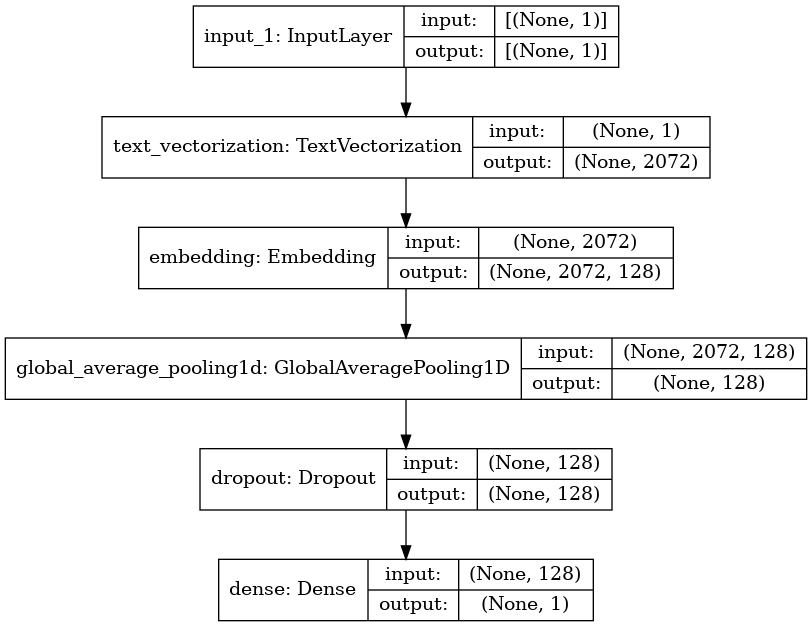

In [37]:
keras.utils.plot_model(model_1,show_shapes=True)

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Compile the model</span>

In [38]:
model_1.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Fit the model</span>



In [39]:
model_1_history=model_1.fit(
    training_dataset,
    epochs=10,
    validation_data=test_dataset
)

Epoch 1/10
158/158 [==============================] - 4s 16ms/step - loss: 0.6708 - accuracy: 0.6005 - val_loss: 0.6418 - val_accuracy: 0.7092
Epoch 2/10
158/158 [==============================] - 2s 16ms/step - loss: 0.6095 - accuracy: 0.7181 - val_loss: 0.5692 - val_accuracy: 0.7702
Epoch 3/10
158/158 [==============================] - 2s 16ms/step - loss: 0.5213 - accuracy: 0.8073 - val_loss: 0.4863 - val_accuracy: 0.8193
Epoch 4/10
158/158 [==============================] - 3s 17ms/step - loss: 0.4390 - accuracy: 0.8467 - val_loss: 0.4239 - val_accuracy: 0.8423
Epoch 5/10
158/158 [==============================] - 2s 16ms/step - loss: 0.3800 - accuracy: 0.8640 - val_loss: 0.3809 - val_accuracy: 0.8542
Epoch 6/10
158/158 [==============================] - 3s 17ms/step - loss: 0.3373 - accuracy: 0.8765 - val_loss: 0.3494 - val_accuracy: 0.8550
Epoch 7/10
158/158 [==============================] - 2s 16ms/step - loss: 0.3046 - accuracy: 0.8866 - val_loss: 0.3256 - val_accuracy: 0.8661

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">model Results</span>



In [40]:
start_time=timeit.default_timer()
model_1_pred_prob=model_1.predict(test_dataset)
model_1_pred=tf.squeeze(tf.round(model_1_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_1_results=binary_clf_evaluation(ytest,model_1_pred,time_taken_per_instance)
display_results(model_1_results)

In [41]:
def plot_loss_curves(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    display(HTML('''<p style="background-color:#6495ED;color:black;font-size:20px;text-align:center;border-radius:30px 60px;font-weight:bold;border:3px solid #6495ED;">Model Performance Curves</p>"'''))
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('loss',size=20)
    plt.legend(fontsize=15);
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('Accuracy',size=20)
    plt.tight_layout()
    plt.legend(fontsize=15);

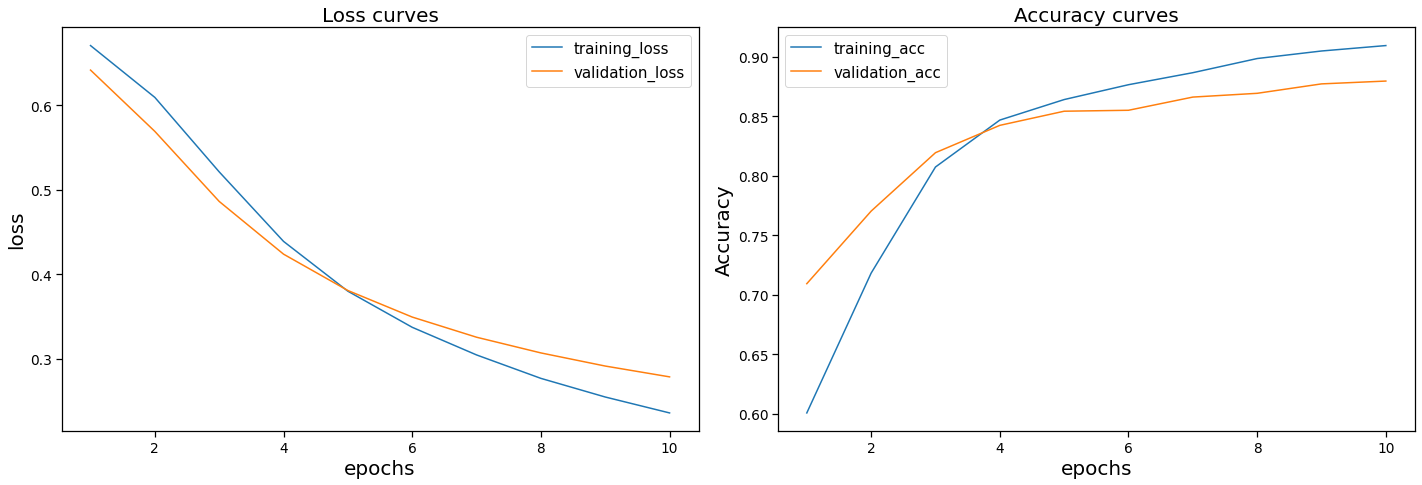

In [42]:
plot_loss_curves(model_1_history)

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Summary</span>


In [43]:
overall_results=store_results(model_1_results,"model_1",overall_results)
overall_results

,accuracy,precision,recall,f1_score,time/instance
model_0,0.847861,0.876489,0.847861,0.844912,0.000625
model_1,0.879556,0.888938,0.879556,0.878826,0.000254



<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 210px">model_2</span>
<h3><li>Using LSTMs.</li><hr></h3>


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Build the model</span>

In [44]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=textVectorizer(inputs)
x=embedding(x)
x=layers.SpatialDropout1D(0.1)(x)
x=layers.LSTM(128,return_sequences=True)(x)
x=layers.Dropout(0.15)(x)
x=layers.LSTM(64,return_sequences=True)(x)
x=layers.Dropout(0.15)(x)
x=layers.LSTM(32)(x)
x=layers.Dropout(0.2)(x)
outputs=layers.Dense(1,activation='sigmoid',dtype=tf.float32)(x)
model_2=keras.models.Model(inputs,outputs,name="model_2")

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">model Summary</span>


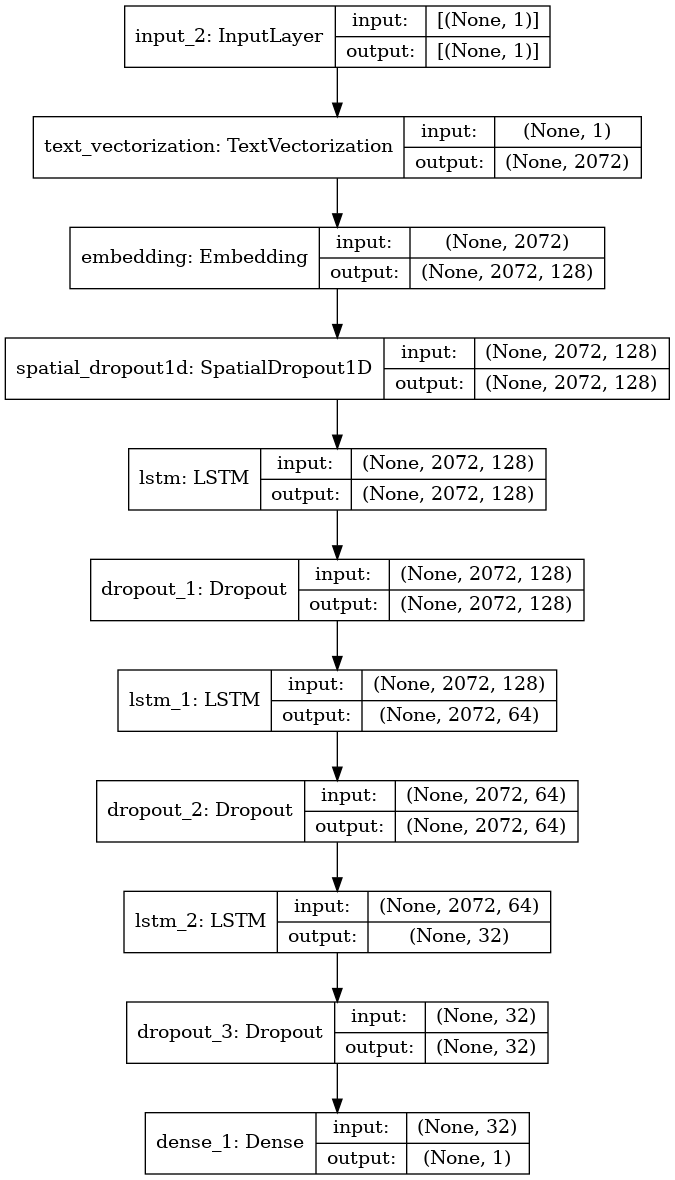

In [45]:
tf.keras.utils.plot_model(model_2,show_shapes=True)


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Compile the model</span>


In [46]:
model_2.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Fit the model</span>


In [47]:
model_2_history=model_2.fit(
    training_dataset,
    epochs=5,
    validation_data=test_dataset
)

Epoch 1/5


2022-04-12 10:15:26.599727: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


158/158 [==============================] - 56s 324ms/step - loss: 0.6869 - accuracy: 0.5214 - val_loss: 0.6858 - val_accuracy: 0.5103
Epoch 2/5
158/158 [==============================] - 49s 313ms/step - loss: 0.6830 - accuracy: 0.5234 - val_loss: 0.6865 - val_accuracy: 0.5103
Epoch 3/5
158/158 [==============================] - 50s 318ms/step - loss: 0.6040 - accuracy: 0.6378 - val_loss: 0.5219 - val_accuracy: 0.7203
Epoch 4/5
158/158 [==============================] - 50s 316ms/step - loss: 0.5149 - accuracy: 0.7353 - val_loss: 0.5231 - val_accuracy: 0.7187
Epoch 5/5
158/158 [==============================] - 50s 320ms/step - loss: 0.5158 - accuracy: 0.7347 - val_loss: 0.5157 - val_accuracy: 0.7258



<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">model Results</span>


In [48]:
start_time=timeit.default_timer()
model_2_pred_prob=model_2.predict(test_dataset)
model_2_pred=tf.squeeze(tf.round(model_2_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_2_results=binary_clf_evaluation(ytest,model_2_pred,time_taken_per_instance)
display_results(model_2_results)

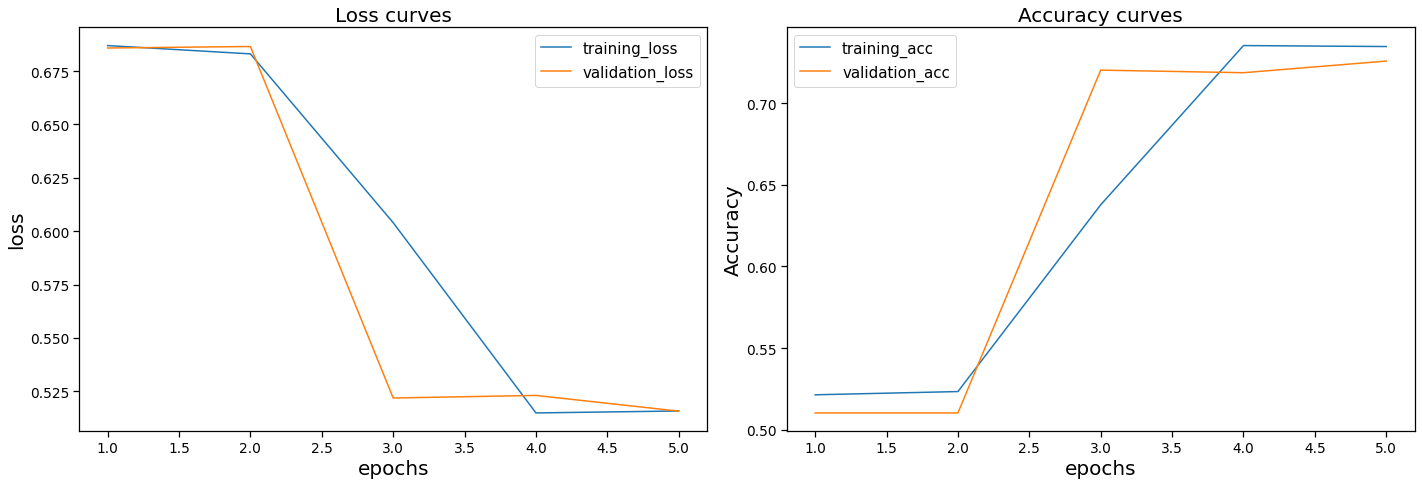

In [49]:
plot_loss_curves(model_2_history)

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Summary</span>


In [50]:
overall_results=store_results(model_2_results,"model_2",overall_results)
overall_results

,accuracy,precision,recall,f1_score,time/instance
model_0,0.847861,0.876489,0.847861,0.844912,0.000625
model_1,0.879556,0.888938,0.879556,0.878826,0.000254
model_2,0.725832,0.816703,0.725832,0.704646,0.004126



<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 210px">model_3</span>
<h3><li>Using Tensorflow pretrained model Universal Sentence Encoder(USE).</li><hr></h3>



<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Build the model</span>


In [51]:
pretained_embedding=hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',trainable=False,input_shape=[],dtype=tf.string,name="USE")
model_3=keras.Sequential([
    pretained_embedding,
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid',dtype=tf.float64)
])


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">model Summary</span>


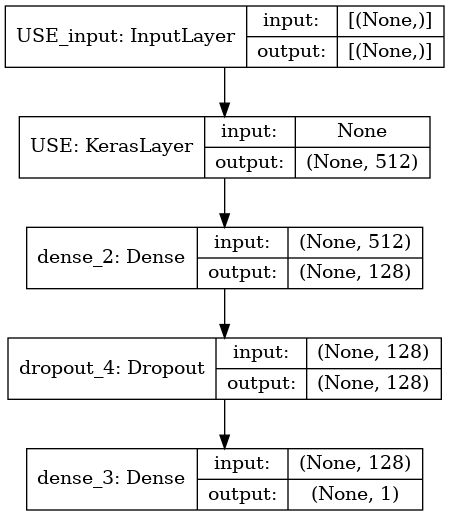

In [52]:
keras.utils.plot_model(model_3,show_shapes=True)

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Compile the model</span>

In [53]:
model_3.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Fit the model</span>

In [54]:
model_3_history=model_3.fit(
    x=training_dataset,
    epochs=5,
    steps_per_epoch=len(training_dataset),
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5
158/158 [==============================] - 29s 171ms/step - loss: 0.4557 - accuracy: 0.8075 - val_loss: 0.3429 - val_accuracy: 0.8566
Epoch 2/5
158/158 [==============================] - 27s 169ms/step - loss: 0.3147 - accuracy: 0.8709 - val_loss: 0.3096 - val_accuracy: 0.8685
Epoch 3/5
158/158 [==============================] - 26s 167ms/step - loss: 0.2829 - accuracy: 0.8824 - val_loss: 0.2960 - val_accuracy: 0.8811
Epoch 4/5
158/158 [==============================] - 26s 162ms/step - loss: 0.2673 - accuracy: 0.8882 - val_loss: 0.2905 - val_accuracy: 0.8803
Epoch 5/5
158/158 [==============================] - 27s 171ms/step - loss: 0.2553 - accuracy: 0.8931 - val_loss: 0.2860 - val_accuracy: 0.8796


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">model Results</span>

In [55]:
start_time=timeit.default_timer()
model_3_pred_prob=model_3.predict(test_dataset)
model_3_pred=tf.squeeze(tf.round(model_3_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_3_results=binary_clf_evaluation(ytest,model_3_pred,time_taken_per_instance)
display_results(model_3_results)

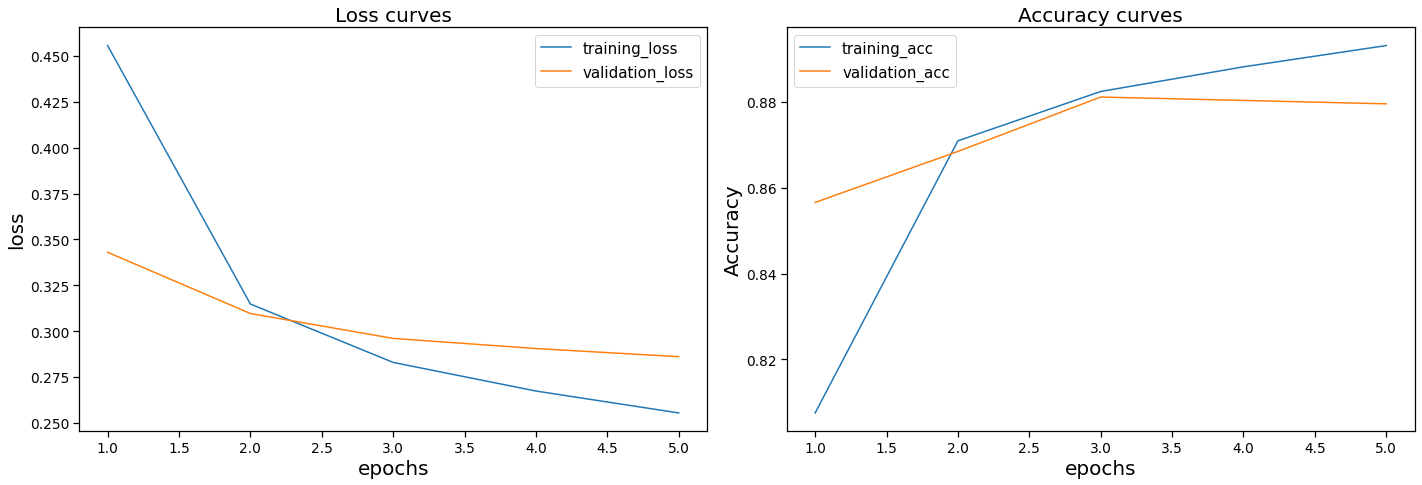

In [56]:
plot_loss_curves(model_3_history)

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Summary</span>


In [57]:
overall_results=store_results(model_3_results,"model_3",overall_results)
overall_results

,accuracy,precision,recall,f1_score,time/instance
model_0,0.847861,0.876489,0.847861,0.844912,0.000625
model_1,0.879556,0.888938,0.879556,0.878826,0.000254
model_2,0.725832,0.816703,0.725832,0.704646,0.004126
model_3,0.879556,0.882357,0.879556,0.879335,0.003699


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 210px">Fine Tunning model_3</span>


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Unfrezzing the layers</span>


In [58]:
mixed_precision.set_global_policy('float64')
pretained_embedding.trainable=True


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Recompile the model</span>


In [59]:
model_3.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Defining Callbacks</span>

In [60]:
early_stopping_cb=keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True,verbose=2)
reduce_lr_cb=keras.callbacks.ReduceLROnPlateau(factor=0.2,patience=2,min_delta=0.001,min_lr=1e-7,verbose=2)

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Fit the model for fine-tunning</span>

In [61]:
model_3_history_fn=model_3.fit(
    training_dataset,
    epochs=30,
    initial_epoch=4,
    validation_data=test_dataset,
    callbacks=[early_stopping_cb,reduce_lr_cb]
)

Epoch 5/30
158/158 [==============================] - 47s 248ms/step - loss: 0.2315 - accuracy: 0.9062 - val_loss: 0.2489 - val_accuracy: 0.8962
Epoch 6/30
158/158 [==============================] - 38s 240ms/step - loss: 0.1451 - accuracy: 0.9510 - val_loss: 0.2271 - val_accuracy: 0.9081
Epoch 7/30
158/158 [==============================] - 39s 248ms/step - loss: 0.0892 - accuracy: 0.9780 - val_loss: 0.2123 - val_accuracy: 0.9136
Epoch 8/30
158/158 [==============================] - 39s 245ms/step - loss: 0.0502 - accuracy: 0.9905 - val_loss: 0.2061 - val_accuracy: 0.9168
Epoch 9/30
158/158 [==============================] - 39s 244ms/step - loss: 0.0279 - accuracy: 0.9972 - val_loss: 0.2264 - val_accuracy: 0.9144
Epoch 10/30
158/158 [==============================] - 38s 242ms/step - loss: 0.0163 - accuracy: 0.9992 - val_loss: 0.2333 - val_accuracy: 0.9120

Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 11/30
158/158 [==========================

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">model Results</span>

In [62]:
start_time=timeit.default_timer()
model_3_pred_prob=model_3.predict(test_dataset)
model_3_pred=tf.squeeze(tf.round(model_3_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_3_results=binary_clf_evaluation(ytest,model_3_pred,time_taken_per_instance)
display_results(model_3_results)

In [63]:
def plot_and_compare_history(original_history,new_history,initial_epoch):
    """
    the function accepts the histories of a model before and after fine-tunning.
    initial_epoch:#epochs used to train the original model.
    """
    display(HTML("<p style='background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px'> Impact of Fine tunning on Performance Curves </p>"))
    #get original history measurements
    acc=original_history.history['accuracy']
    loss=original_history.history['loss']
    val_acc=original_history.history['val_accuracy']
    val_loss=original_history.history['val_loss']
    
    #combining 
    total_acc=acc+new_history.history['accuracy']
    total_loss=loss+new_history.history['loss']
    total_val_acc=val_acc+new_history.history['val_accuracy']
    total_val_loss=val_loss+new_history.history['val_loss']
    
    #make plots
    plt.figure(figsize=(24,8))
    plt.subplot(1,2,1)
    plt.plot(total_acc,label='Training Accuracy')    
    plt.plot(total_val_acc,label='Validation Accuracy')
    plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(),label='Start fine tunning')
    plt.title("Accuracy",size=20)
    plt.xlabel("Epochs",size=15)
    plt.ylabel("Loss",size=15)
    plt.legend(loc='lower right')
    plt.subplot(1,2,2)
    plt.plot(total_loss,label='Training loss')
    plt.plot(total_val_loss,label="Validation loss")
    plt.plot([initial_epoch-1,initial_epoch-1],plt.ylim(),label='Start fine tunning')
    plt.title("Loss",size=20)
    plt.ylabel('Accuracy',size=15)
    plt.xlabel("Epochs",size=15)
    plt.legend(loc="upper right")
    plt.tight_layout();

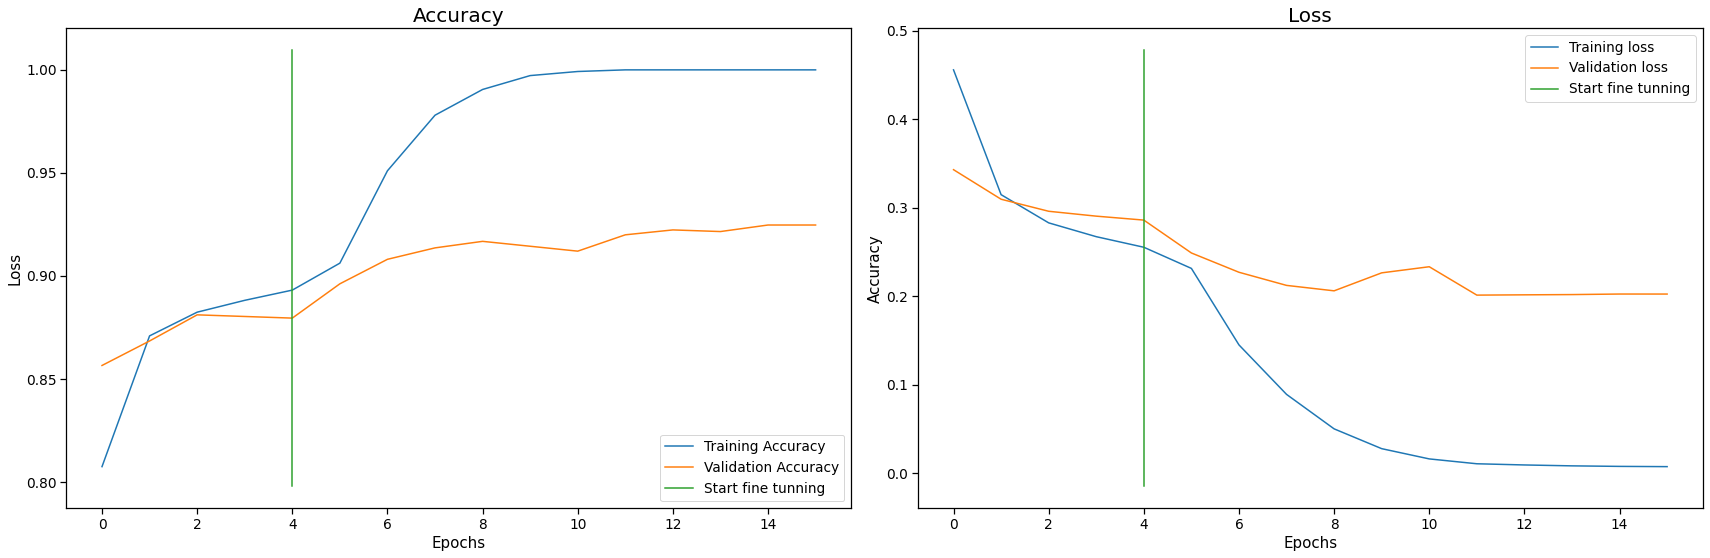

In [64]:
plot_and_compare_history(model_3_history,model_3_history_fn,initial_epoch=5)

In [65]:
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>Fine-tunning the model was beneficial in further improving the performance of the model.</li></ul></h3>"))

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Summary</span>

In [66]:
overall_results=store_results(model_3_results,"model_3_fn",overall_results)
overall_results

,accuracy,precision,recall,f1_score,time/instance
model_0,0.847861,0.876489,0.847861,0.844912,0.000625
model_1,0.879556,0.888938,0.879556,0.878826,0.000254
model_2,0.725832,0.816703,0.725832,0.704646,0.004126
model_3,0.879556,0.882357,0.879556,0.879335,0.003699
model_3_fn,0.919968,0.920054,0.919968,0.919964,0.003567


In [67]:
del df,xtrain,xtest,ytrain,ytest
gc.collect()

7086

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 210px">model_4</span>
<h3><li>Using Transformers,fine tunning pretrained model from HuggingFace Model Hub using 20% of the training batches.</li><hr></h3>


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Loading Data</span>


In [68]:
data=load_dataset('csv',data_files='../input/fake-or-real-news/fake_or_real_news.csv')
data

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-5ee412b4f77dc510/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 6335
    })
})

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Encoding the labels</span>


In [69]:
def label_encoding(example):
    if example['label']=='FAKE':
        example['label']=0
    else:
        example['label']=1
    return example

data=data.map(label_encoding)

0ex [00:00, ?ex/s]

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Tokenization</span>


In [70]:
checkpoint='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(checkpoint)

#defining the merging function
def merge(example):
    example['text']=example['title']+"\n"+example['text']
    return example

#defining the tokenization function
def tokenize_function(example):
    return tokenizer(example['text'],truncation=True)

data=data.map(merge)

tokenized_dataset=data.map(tokenize_function,batched=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

0ex [00:00, ?ex/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [71]:
#policy to be used while batching
data_collator=DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='tf')

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Split Data into train and test</span>


In [72]:
tokenized_splitted_dataset=tokenized_dataset['train'].train_test_split(test_size=0.2)
test_set_lenght=len(tokenized_splitted_dataset['test']['label'])
tokenized_splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5068
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1267
    })
})

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Converting Data into Data Batches</span>


In [73]:
tf_train_dataset = tokenized_splitted_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=4,
).prefetch(tf.data.AUTOTUNE)

tf_validation_dataset = tokenized_splitted_dataset["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=4,
).prefetch(tf.data.AUTOTUNE)

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Build the model</span>


In [74]:
model_4 = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=1)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Compile the model</span>


In [75]:
# defining Learning rate ploynomial decay callback
epochs=3
mini_batches=int(0.2*len(tf_train_dataset))
num_steps=epochs*mini_batches
learning_rate_schedule=PolynomialDecay(
    initial_learning_rate=5e-5,
    decay_steps=num_steps,
    end_learning_rate=0.0,   
)


model_4.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_schedule),
    metrics=['accuracy']
)

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Fit the model</span>


In [76]:
model_4_history=model_4.fit(
    tf_train_dataset,
    steps_per_epoch=int(0.2*len(tf_train_dataset)),
    epochs=epochs,
    validation_data=tf_validation_dataset,
    validation_steps=len(tf_validation_dataset)
)

Epoch 1/3
253/253 [==============================] - 242s 881ms/step - loss: 0.4589 - accuracy: 0.7737 - val_loss: 0.2338 - val_accuracy: 0.9211
Epoch 2/3
253/253 [==============================] - 220s 870ms/step - loss: 0.2329 - accuracy: 0.9160 - val_loss: 0.1447 - val_accuracy: 0.9558
Epoch 3/3
253/253 [==============================] - 220s 870ms/step - loss: 0.1180 - accuracy: 0.9575 - val_loss: 0.1218 - val_accuracy: 0.9534


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">model Results</span>


In [77]:
start_time=timeit.default_timer()
model_4_pred_logits=model_4.predict(tf_validation_dataset)
model_4_pred=tf.round(tf.nn.sigmoid(model_4_pred_logits['logits']))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/test_set_lenght
model_4_results=binary_clf_evaluation(tokenized_splitted_dataset['test']['label'],model_4_pred,time_taken_per_instance)
display_results(model_4_results)

In [78]:
display(HTML(f"<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>The Transformer based model was able to outperform all the previous models while trained on only 20% of training batches.</li></ul></h3>"))

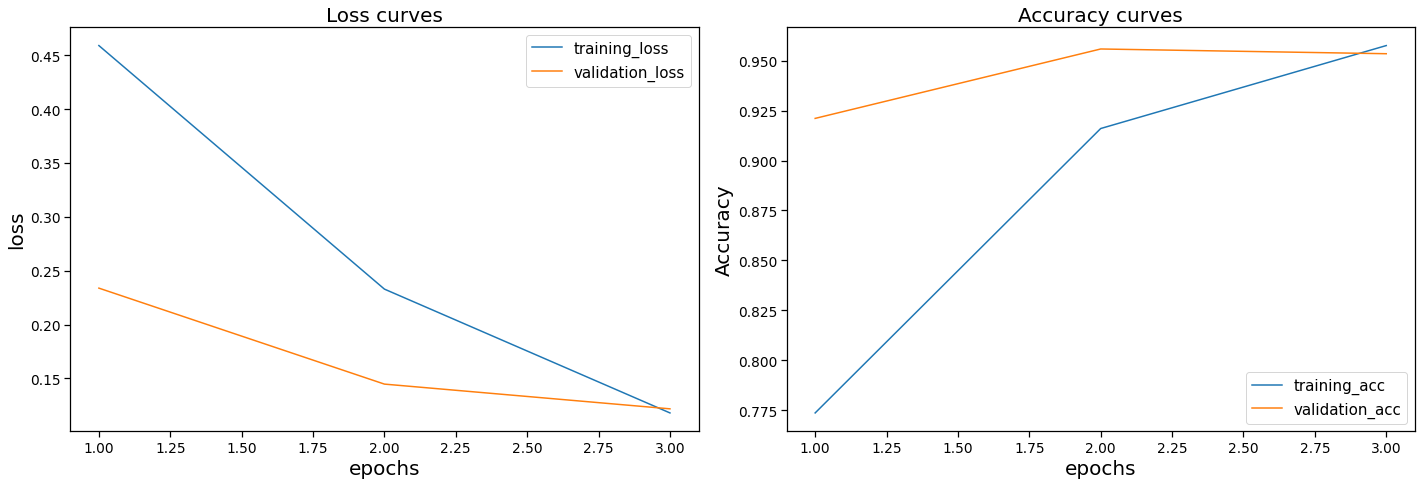

In [79]:
plot_loss_curves(model_4_history)

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Summary</span>


In [80]:
overall_results=store_results(model_4_results,"model_4",overall_results)
overall_results

,accuracy,precision,recall,f1_score,time/instance
model_0,0.847861,0.876489,0.847861,0.844912,0.000625
model_1,0.879556,0.888938,0.879556,0.878826,0.000254
model_2,0.725832,0.816703,0.725832,0.704646,0.004126
model_3,0.879556,0.882357,0.879556,0.879335,0.003699
model_3_fn,0.919968,0.920054,0.919968,0.919964,0.003567
model_4,0.955012,0.955102,0.955012,0.955009,0.048964


<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Best model as per f1_score</span>


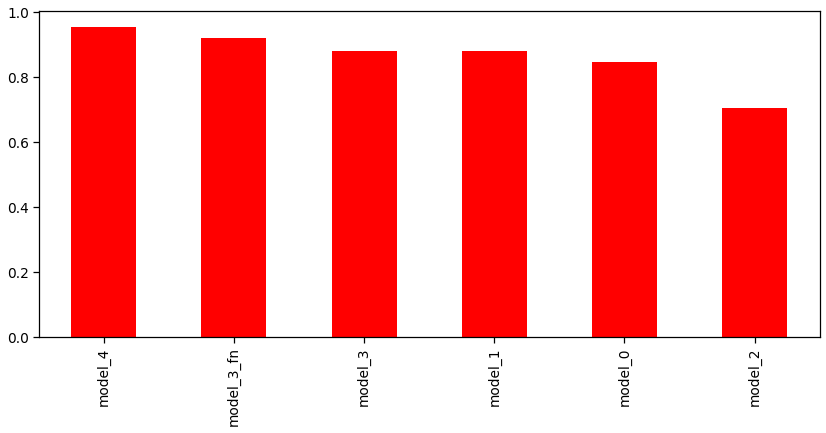

In [81]:
overall_results.sort_values(by='f1_score',ascending=False)['f1_score'].plot(kind='bar',figsize=(14,6),color='red');

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 20px">Best model as per time taken/prediction</span>

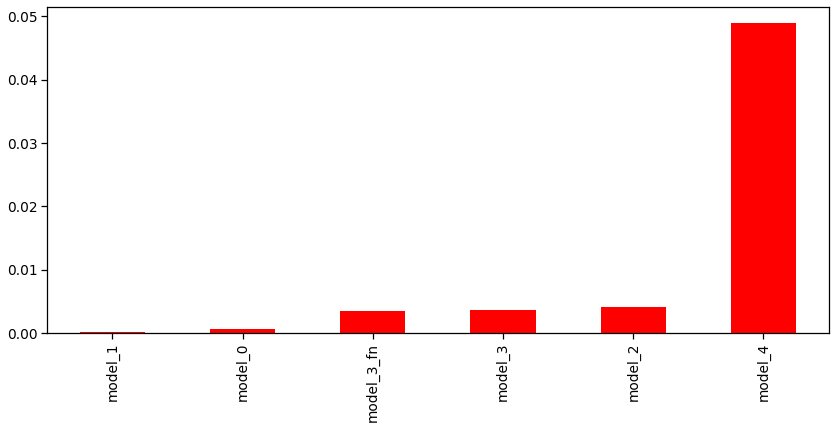

In [82]:
overall_results.sort_values(by='time/instance',ascending=True)['time/instance'].plot(kind='bar',figsize=(14,6),color='red');

<span style="background-color:#6495ED;color:white;font-size:22px;text-align:center;border-radius:30px 60px;font-weight:bold;border:2px solid #6495ED;padding:0px 210px">model f1_score vs time/instance</span>


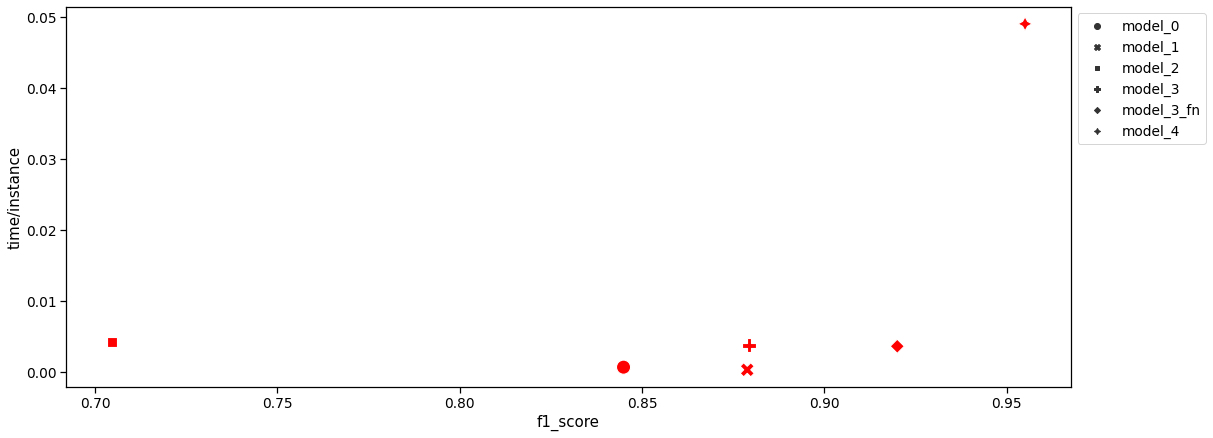

In [83]:
plt.figure(figsize=(18,7))
sns.scatterplot(data=overall_results,x='f1_score',y='time/instance',s=200,color='red',style=overall_results.index);
plt.legend(bbox_to_anchor=(1.0,1.0));

<h3>  <b style='color:red;font-size:22px;'>Inference </b>:<ul><li>We will not find the model which has best of two worlds that is higher f1_score and lower time/instance.</li><br>
    <li> Depending upon our need we need to comprise on one front.</li><br>
    <li> If our need is being accurate then we will have compromise on time taken per prediction and if our need is speed of prediction taken accuracy will be compromised.</li><br>
    <li> In my opiniion model_1 is consistant on both fronts and will work well in most systems.</li>
 </ul></h3>


<h2 style='text-align:center;color:#FF3355;font-weight:bold'> Do share your feedback in the comments section,I hope you found it to be helpful.🙌</h2>


<p style="background-color:#6495ED;color:black;font-size:22px;text-align:center;border-radius:10px 10px;font-weight:bold;border:2px solid #6495ED;">Thank you😄!!!!!!</p>